In [34]:
# https://xilinx.github.io/brevitas/getting_started.html

from torch import nn
from torch.nn import Module
import torch.nn.functional as F
import brevitas.nn as qnn
import torch 

import os
import onnx
# import torch
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset
from brevitas.nn import QuantLinear, QuantReLU
# import torch.nn as nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

weight_bit_width = 4

class QuantWeightLeNet(Module):
    def __init__(self):
        super(QuantWeightLeNet, self).__init__()
        self.conv1 = qnn.QuantConv2d(3, 6, 5, bias=True, weight_bit_width=weight_bit_width)
        self.relu1 = nn.ReLU()
        self.conv2 = qnn.QuantConv2d(6, 16, 5, bias=True, weight_bit_width=weight_bit_width)
        self.relu2 = nn.ReLU()
        self.fc1   = qnn.QuantLinear(16*5*5, 120, bias=True, weight_bit_width=weight_bit_width)
        self.relu3 = nn.ReLU()
        self.fc2   = qnn.QuantLinear(120, 84, bias=True, weight_bit_width=weight_bit_width)
        self.relu4 = nn.ReLU()
        self.fc3   = qnn.QuantLinear(84, 10, bias=True, weight_bit_width=weight_bit_width)

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = self.relu2(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.reshape(out.shape[0], -1)
        out = self.relu3(self.fc1(out))
        out = self.relu4(self.fc2(out))
        out = self.fc3(out)
        return out

model = QuantWeightLeNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

model.to(device); # The semicolon is for not printing the model.


Target device: cpu


### Data processing

In [29]:
# This is for bit quantization. The quantization value can be changed in line 11. 

import numpy as np
import torchvision
import torchvision.transforms as transforms
import os

quant_param = 4 # log2(quant_param) bits. #256 means no quanization, 1 means 1-bit quantization

def quantize_image(image):
    """Quantize and binarize an image."""
    image = image.astype(np.float32)
    image = np.floor(image / (256/quant_param))  # Example: reducing to 4-bit quantization
    return image.astype(np.float32)

def save_dataset_as_npz(data, labels, filename):
    """Save the dataset as a .npz file."""
    np.savez_compressed(filename, data=data, labels=labels)

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Quantize the images
train_images = np.array([quantize_image(image.numpy().transpose(1, 2, 0) * 255) for image, _ in train_dataset])
train_labels = np.array(train_dataset.targets)

test_images = np.array([quantize_image(image.numpy().transpose(1, 2, 0) * 255) for image, _ in test_dataset])
test_labels = np.array(test_dataset.targets)

# Save the datasets
os.makedirs('./quantized_data', exist_ok=True)
save_dataset_as_npz(train_images, train_labels, './quantized_data/cifar10_train.npz')
save_dataset_as_npz(test_images, test_labels, './quantized_data/cifar10_test.npz')

# data = np.load('./quantized_data/cifar10_train.npz')
# # print(data.files)
# print(data['data'].shape)
# print(data['labels'].shape)
# print(data['data'][328][15])
# print(data['labels'][328])

Files already downloaded and verified
Files already downloaded and verified


In [30]:
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import time

class CIFAR10QuantizedDataset(Dataset):
    def __init__(self, npz_file):
        data = np.load(npz_file)
        self.images = data['data']
        self.labels = data['labels']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        label = self.labels[idx]
        image = torch.tensor(image.transpose(2, 0, 1))  # HWC to CHW format
        label = torch.tensor(label, dtype=torch.long)
        return image, label

# Load the quantized dataset
train_dataset = CIFAR10QuantizedDataset('./quantized_data/cifar10_train.npz')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CIFAR10QuantizedDataset('./quantized_data/cifar10_test.npz')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### Training and testing

In [35]:
import torch.optim as optim

def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(images.float())
        # loss = criterion(output, labels.unsqueeze(1))
        loss = criterion(output, labels)
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.data.cpu().numpy()) 
    return losses


def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            output = model(images.float())
            # run the output through sigmoid
            # output = torch.sigmoid(output_orig)  
            # compare against a threshold of 0.5 to generate 0/1
            # pred = (output.detach().cpu().numpy() > 0.5) * 1
            _, pred = torch.max(output.data, 1)
            labels = labels.cpu().float()
            y_true.extend(labels.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
            # y_pred.extend((pred == labels).sum().item())
        
    return accuracy_score(y_true, y_pred)

num_epochs = 10
lr = 0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# loss criterion and optimizer
# criterion = nn.BCEWithLogitsLoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train(model, train_loader, optimizer,criterion)
        test_acc = test(model, test_loader)
        t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)


Training loss = 1.615079 test accuracy = 0.411900: 100%|█| 10/10 [01:21<00:00,  


In [ ]:
test_accuracy = test(model, test_loader)
print('test accuracy = ', test_accuracy)

In [ ]:
# Save the Brevitas model to disk
torch.save(model.state_dict(), "state_dict_LeNet_Weight.pth")

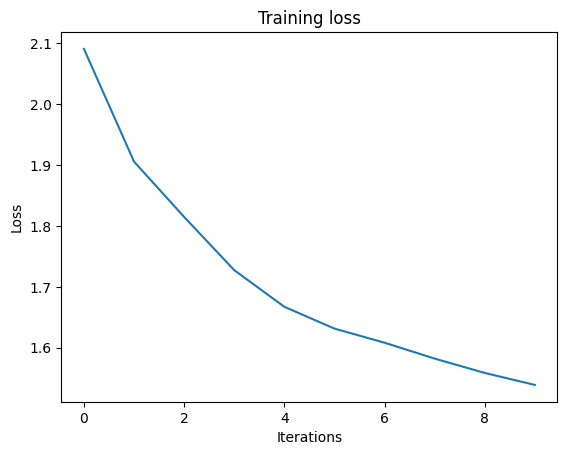

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

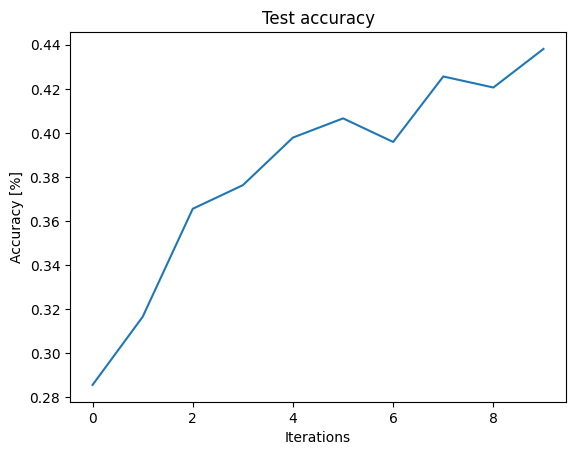

In [33]:
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

####  Convert to ONNX model

In [36]:
from brevitas.export import export_onnx_qcdq
import torch

# Weight-only model
export_onnx_qcdq(model, torch.randn(1, 3, 32, 32), export_path='4b_weightonly_lenet.onnx')


/home/inets/arish/FINN_arish/finn/deps/brevitas/src/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


ir_version: 7
producer_name: "pytorch"
producer_version: "1.13.1"
graph {
  node {
    input: "/conv1/weight_quant/export_handler/Constant_2_output_0"
    input: "/conv1/weight_quant/export_handler/Constant_3_output_0"
    input: "/conv1/weight_quant/export_handler/Constant_4_output_0"
    output: "/conv1/weight_quant/export_handler/Clip_output_0"
    name: "/conv1/weight_quant/export_handler/Clip"
    op_type: "Clip"
  }
  node {
    input: "/conv1/weight_quant/export_handler/Clip_output_0"
    input: "/conv1/weight_quant/export_handler/Constant_output_0"
    input: "/conv1/weight_quant/export_handler/Constant_1_output_0"
    output: "/conv1/weight_quant/export_handler/DequantizeLinear_output_0"
    name: "/conv1/weight_quant/export_handler/DequantizeLinear"
    op_type: "DequantizeLinear"
  }
  node {
    input: "x.5"
    input: "/conv1/weight_quant/export_handler/DequantizeLinear_output_0"
    input: "conv1.bias"
    output: "/conv1/Conv_output_0"
    name: "/conv1/Conv"
    op_type